### Loading the CSV

In [101]:
import pandas as pd
pd.set_option("display.max_colwidth", 500)
dataset = pd.read_csv("data/books.csv")

### Let's investigate the data and see what all is there

In [70]:
dataset.columns

Index(['isbn13', 'isbn10', 'title', 'subtitle', 'authors', 'categories',
       'thumbnail', 'description', 'published_year', 'average_rating',
       'num_pages', 'ratings_count'],
      dtype='object')

We will now see all the possibly missing data points in this data set

In [71]:
dataset.shape

(6810, 12)

In [72]:
print("Missing values in this dataset: -\n")
for col in dataset.columns:
    print(f"{col} : {dataset[col].isna().sum()}")

Missing values in this dataset: -

isbn13 : 0
isbn10 : 0
title : 0
subtitle : 4429
authors : 72
categories : 99
thumbnail : 329
description : 262
published_year : 6
average_rating : 43
num_pages : 43
ratings_count : 43


The subtitle column has a lot of missing values so we'll be unable to use that, we'll drop that fully.
On the other hand the description is the column of interest for us. We need to see if the missing values are randomly distributed or they have a bias, and also if the missing values in the other columns show some bias.
To do that we need to plot the rows on the X-axis and the Columns in the Y-axis and then the resulting graph will show us the pattern of the missing values.

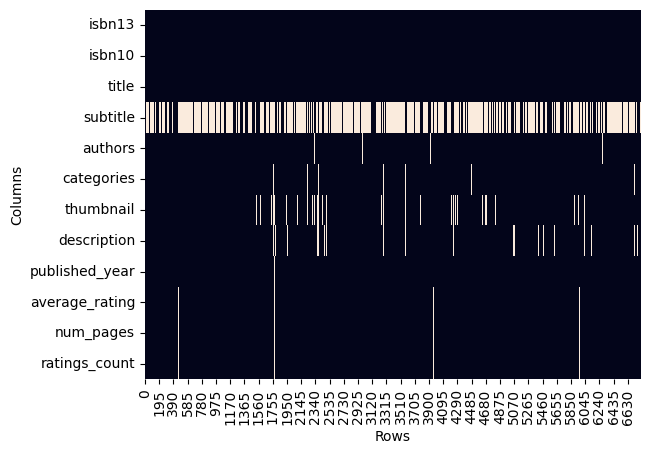

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = plt.axes()
sns.heatmap(dataset.isna().transpose(), cbar=False, ax=ax)

plt.xlabel("Rows")
plt.ylabel("Columns")

plt.show()

The above graph shows the light color as 1 or True and blue color as 0 or False. Meaning the light color is Null value and dark color is not null value.

My Observations:
- It doesn't seem like the description has any pattern of disappearance, it's pretty random in itself
- Though the average rating, num_pages and rating_count do show some similarities in disappearance, there are rows which are similarly gone in all three categories

This pattern shows this dataset was made by combining another dataset in which some of the books in the parent dataset were missing. That dataset in itself could have been biased, to now check if that created a bias in our dataset, we'll run another analysis. 

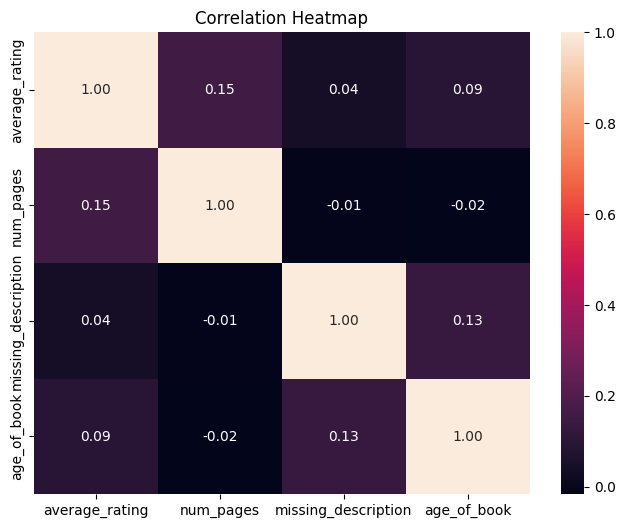

In [74]:
from datetime import datetime
import numpy as np

CURRENT_YEAR = datetime.now().year

dataset["missing_description"] = np.where(dataset["description"].isna(), 1, 0)
dataset["age_of_book"] = CURRENT_YEAR - dataset["published_year"]

# Now let's build a correlation matrix to see if there are any correlations between them
cols_of_interest = ["average_rating", "num_pages", "missing_description", "age_of_book"]

correlation_matrix = dataset[cols_of_interest].corr(method="spearman")

plt.figure(figsize=(8,6))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
heatmap.set_title("Correlation Heatmap")
plt.show()

This clears some things up, there doesn't seem to be any correlation between the other numerical columns and the missing_description.
Hence we can go ahead with our analysis

Now let's see how many total missing books are present which we have to remove from our dataset, we'll only check the missing data from the cols of our interest

In [75]:
discard_dataset = dataset[(dataset["description"].isna())|
        dataset["num_pages"].isna()|
        dataset["average_rating"].isna()|
        dataset["published_year"].isna()]

print(f"The percentage of missing books in the dataset is {discard_dataset.shape[0] / dataset.shape[0] * 100: .2f}")

The percentage of missing books in the dataset is  4.45


In [76]:
# So we are going to exclude these books and include the rest we are going to do this by doing a simple negation of logic.

cleaned_dataset = dataset[(~dataset["description"].isna()) &
        ~dataset["num_pages"].isna() &
        ~dataset["average_rating"].isna() &
        ~dataset["published_year"].isna()]
cleaned_dataset.shape

(6507, 14)

Now we will clean out the things which aren't explicitly missing but not usable. Which are as follows: -
- In the description column if the description is very short it will be no use to us.
- The categories in this dataset is also verbose and repetitive hence we will also remove, all the redundant categories
- And to salvage what all titles we have we will concatenate all the titles and subtitles where the subtitle is not present

<Axes: xlabel='categories'>

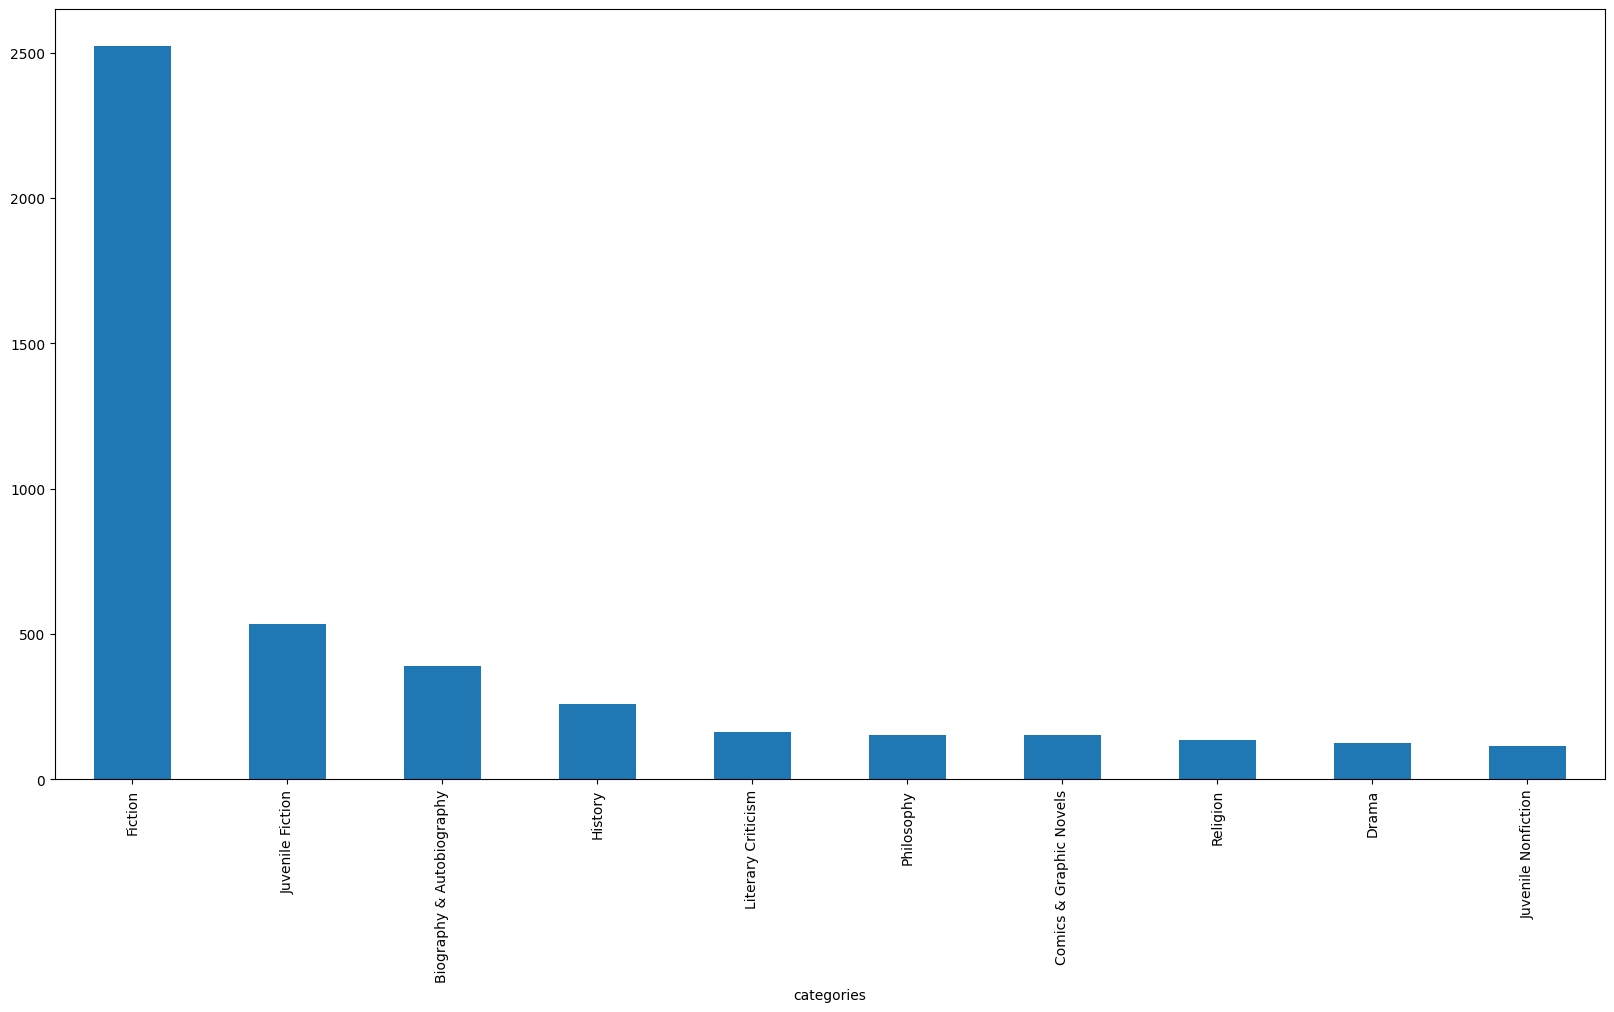

In [80]:
new_plot = cleaned_dataset["categories"].value_counts()[:10]
new_plot.plot(kind="bar", figsize=(20,10))

<Axes: xlabel='categories'>

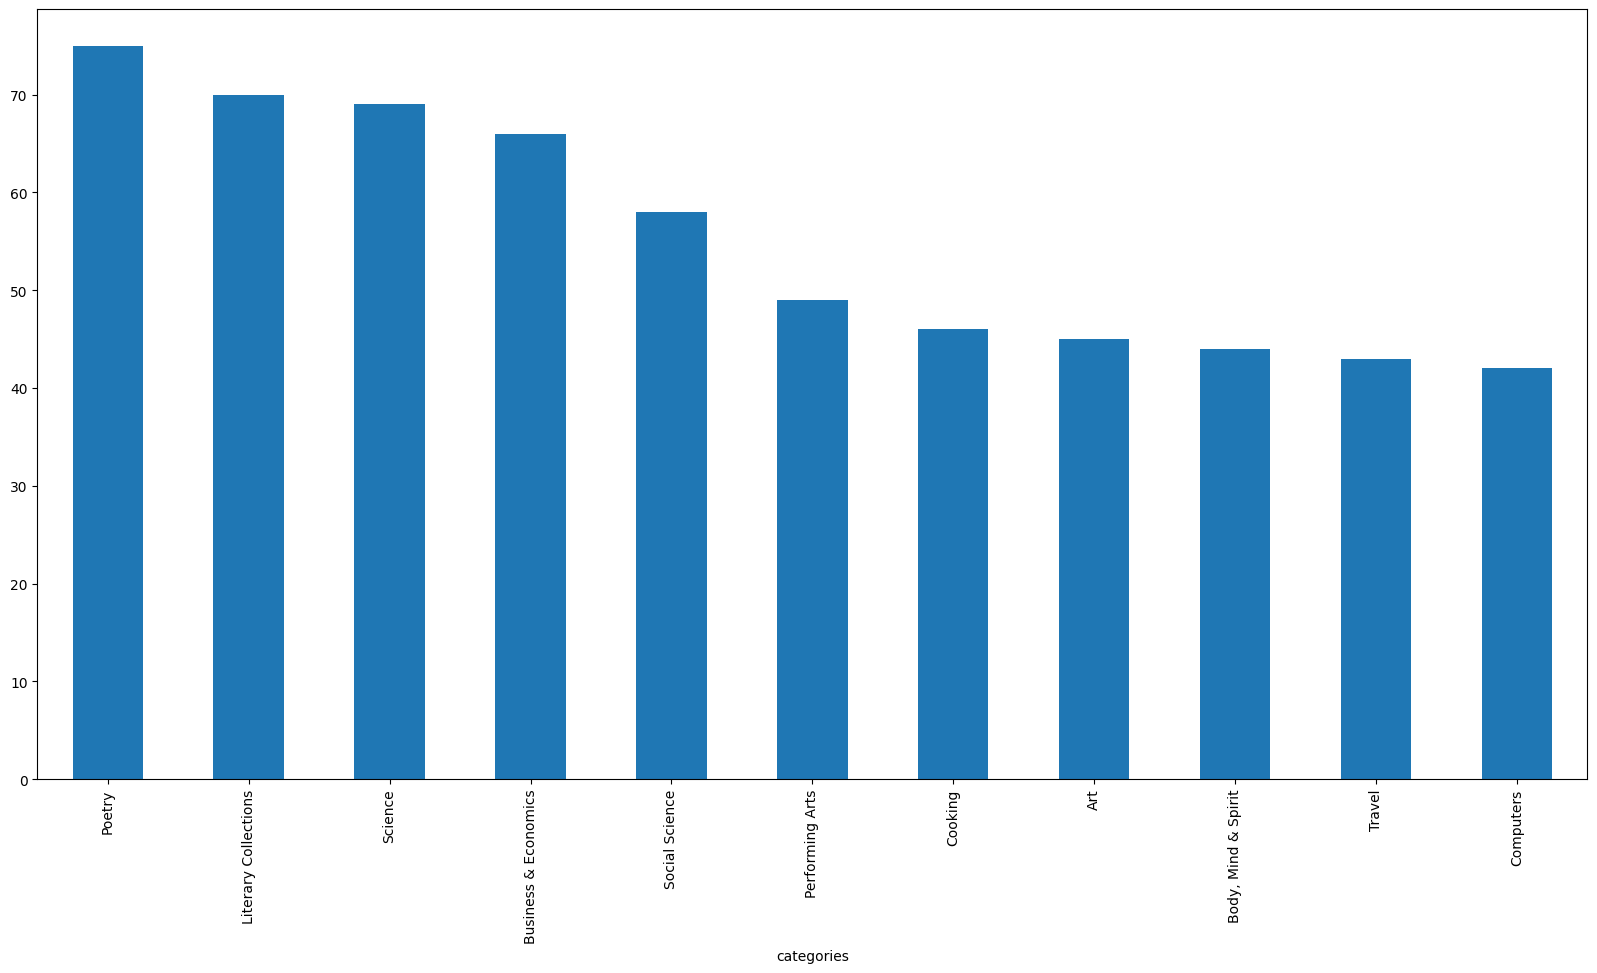

In [81]:
new_plot = cleaned_dataset["categories"].value_counts()[10:21]
new_plot.plot(kind="bar", figsize=(20,10))

Here we see the categories fall off rather quickly. The 20th category only having 40 to 50 books or so.
So we can prune our category list and not include so many

In [82]:
# TODO: Only have the needed categories

Now we need to prune the description, lets see why

C:\Users\varun\AppData\Local\Temp\ipykernel_47096\343577514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset["words_in_desc"] = cleaned_dataset["description"].str.split().str.len()


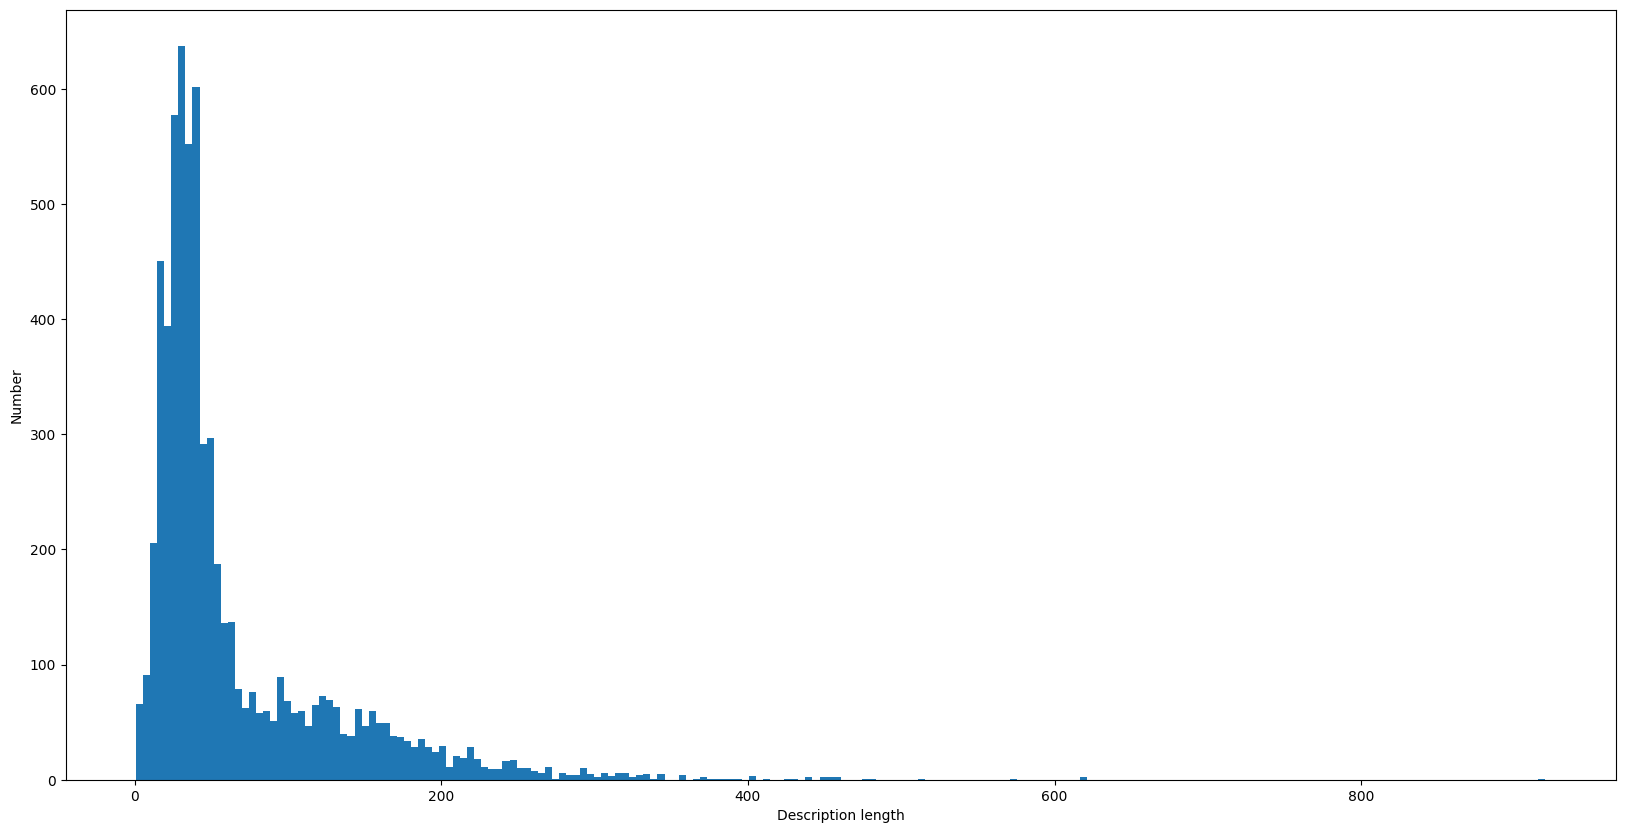

In [94]:
cleaned_dataset["words_in_desc"] = cleaned_dataset["description"].str.split().str.len()
plt.figure(figsize=(20,10))
plt.hist(cleaned_dataset["words_in_desc"], bins=200)
plt.xlabel("Description length")
plt.ylabel("Number")
plt.show()

This shows that most books here have the average length of the description being equal to between 0 to 100, but if there are very less number of words let's say 5 words that is of no use to us, hence we need to remove that as well. We will inspect each bin from 0 to see which should go on.

In [103]:
cleaned_dataset.loc[cleaned_dataset["words_in_desc"].between(1,10), "description"]

6                                                         Donation.
11                                                   Fantasy-roman.
77                                   Nonsense rhyming story. 4 yrs+
104                                  Library of Liberal Arts title.
241          Originally published: [New York]: Clarion Books, 1994.
                                   ...                             
6721                                                        Horror.
6726                 Presents two complete novels from Henry James.
6757                                    Audio Book- unabriged on CD
6794                                           源氏物語54帖、「宮田切り絵」の真骨頂。
6795    Book Of Five Rings is a Kodansha International publication.
Name: description, Length: 157, dtype: object

In [102]:
cleaned_dataset.loc[cleaned_dataset["words_in_desc"].between(10,21), "description"]

2                                             Volume Two of Stephen Donaldson's acclaimed second trilogy featuing the compelling anti-hero Thomas Covenant.
10                                       One of Sidney Sheldon's most popular and bestselling titles, repackaged and reissued for a new generation of fans.
32                                                             Tells the story of three generations of Chinese women, beginning at the turn of the century.
38                                                                           Koko is Peter Straub's foray into the psychological horror of the Vietnam War.
57                                       A young drifter finds more than he bargained for when he agrees to deliver a parcel to an English country house...
                                                                               ...                                                                         
6767                                                            

In [104]:
cleaned_dataset.loc[cleaned_dataset["words_in_desc"].between(20,31), "description"]

9                                                     Kate Blackwell is an enigma and one of the most powerful women in the world. But at her ninetieth birthday celebrations there are ghosts of absent friends and absent enemies.
14                                               Available in the U.S. for the first time, this is the second volume in the exceptional Legends of the Riftwar series from "New York Times"-bestselling authors Feist and Rosenberg.
21                          Reissue of the author's most famous and well-loved work, the Starbridge series, six self-contained yet interconnected novels that explore the history of the Church of England through the 20th century.
36                                                                                       A magical and fantastic collection of early stories by one of the most original children's authors of the 20th century. For 8-11 year olds.
46                                                               No one believes a l

In [105]:
cleaned_dataset.loc[cleaned_dataset["words_in_desc"].between(30,41), "description"]

9                                                                                                                           Kate Blackwell is an enigma and one of the most powerful women in the world. But at her ninetieth birthday celebrations there are ghosts of absent friends and absent enemies.
20                                                                                                   It is 1937, and Charles Ashworth, a Canon to the Archbishop of Canterbury, is sent to untangle a web of self-delusion and corruption at the episcopal palace of the charismatic Bishop of Starbridge.
21                                                                                                Reissue of the author's most famous and well-loved work, the Starbridge series, six self-contained yet interconnected novels that explore the history of the Church of England through the 20th century.
25                                               Miss Marple featured in 20 short stories, published in

Seems like the descriptions above 20 can provide enough for it to be meaningful to put in our model

In [109]:
pd.set_option("display.max_colwidth", 50)
cleaned_dataset_filtered = cleaned_dataset[cleaned_dataset["words_in_desc"] >= 21]
cleaned_dataset_filtered

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_desc
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,21.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,25.0,205
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,32.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,23.0,45
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,23.0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,22.0,288
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,23.0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,22.0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,26.0,174


We'll make some more combinations, finishing touches

In [117]:
cleaned_dataset_filtered["title_and_subtitle"] = (np.where(cleaned_dataset_filtered["subtitle"].isna(), 
                                                           cleaned_dataset_filtered['title'],
                                                           cleaned_dataset_filtered[['title', 'subtitle']].astype(str).agg(": ".join, axis=1)))
cleaned_dataset_filtered["title_and_subtitle"]
cleaned_dataset_filtered["tagged_desc"] = cleaned_dataset_filtered[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)
cleaned_dataset_filtered["tagged_desc"]

C:\Users\varun\AppData\Local\Temp\ipykernel_47096\120708092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset_filtered["title_and_subtitle"] = (np.where(cleaned_dataset_filtered["subtitle"].isna(),
C:\Users\varun\AppData\Local\Temp\ipykernel_47096\120708092.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataset_filtered["tagged_desc"] = cleaned_dataset_filtered[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)


0       9780002005883 A NOVEL THAT READERS and critics...
1       9780002261982 A new 'Christie for Christmas' -...
3       9780006178736 A memorable, mesmerizing heroine...
4       9780006280897 Lewis' work on the nature of lov...
5       9780006280934 "In The Problem of Pain, C.S. Le...
                              ...                        
6802    9788172235222 On A Train Journey Home To North...
6803    9788173031014 This book tells the tale of a ma...
6804    9788179921623 Wisdom to Create a Life of Passi...
6805    9788185300535 This collection of the timeless ...
6808    9789027712059 Since the three volume edition o...
Name: tagged_desc, Length: 5595, dtype: object

Now finally we'll make a new csv file which has all the required columns from our dataset

In [119]:
(
    cleaned_dataset_filtered
    .drop(["subtitle", "missing_description", "age_of_book", "words_in_desc"], axis=1)
    .to_csv("./data/books_cleaned.csv", index=False)
)